In [21]:
import wave
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # SVM classifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score



In [22]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq  # Normalize the lowcut frequency
    high = highcut / nyq  # Normalize the highcut frequency
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def low_pass_filter(data, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

def high_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

In [23]:
with wave.open("single_wheeze_inspire.wav", 'rb') as wav_file:
    num_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    fs = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    duration = num_frames / fs

    frames = wav_file.readframes(num_frames)

print(num_channels)
audio_data = np.frombuffer(frames, dtype=np.int16)
time_axis = np.linspace(0, num_frames / fs, num=num_frames)
print(audio_data)

1
[   0    0    0 ...   71  -98 -249]


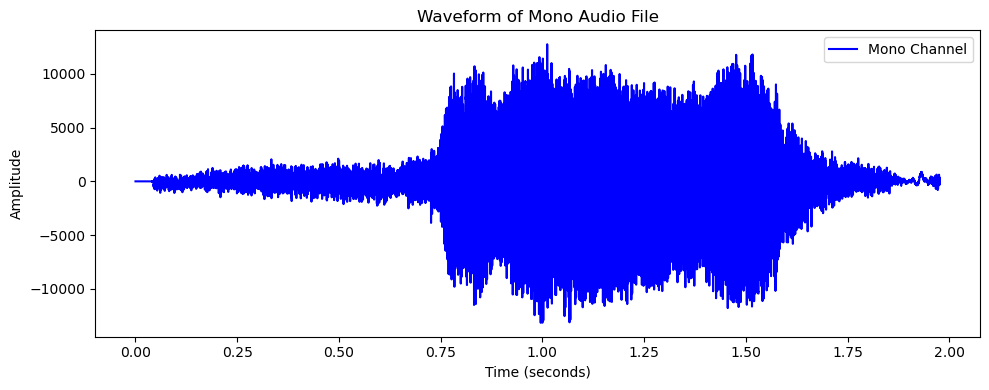

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(time_axis, audio_data, label="Mono Channel", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of Mono Audio File")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
audio_data = high_pass_filter(audio_data, 7.5, fs, 1)
audio_data = low_pass_filter(audio_data, (fs/2)-100, fs, 8)
audio_data = bandpass_filter(audio_data, 80, 1600, fs, 4)


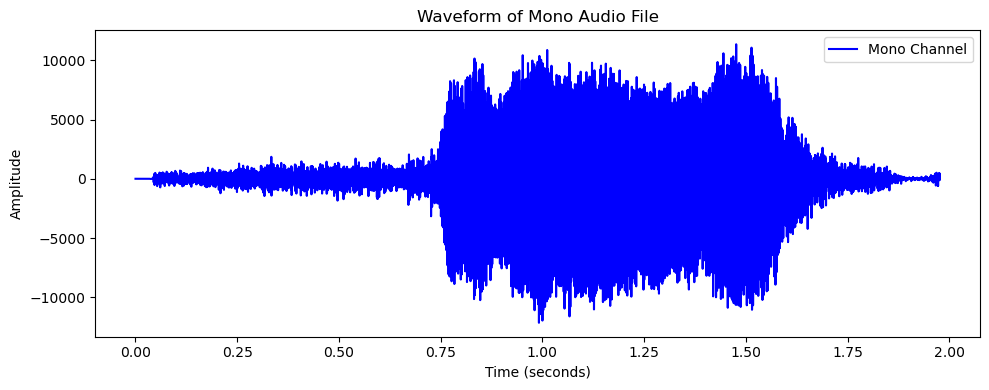

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(time_axis, audio_data, label="Mono Channel", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of Mono Audio File")
plt.legend()
plt.tight_layout()
plt.show()

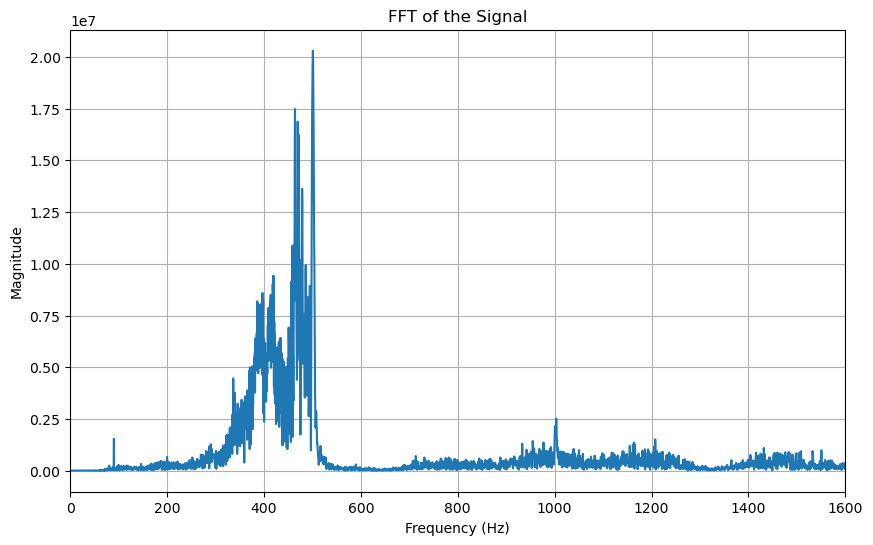

In [27]:
fft_values = np.fft.fft(audio_data)
fft_freq = np.fft.fftfreq(len(audio_data), 1/fs)  # Frequency values for the x-axis

# Take the magnitude of the FFT and plot
magnitude = np.abs(fft_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[:len(fft_freq)//2], magnitude[:len(magnitude)//2])  # Only plot positive frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of the Signal')
plt.xlim(0, 1600)
plt.grid()
plt.show()

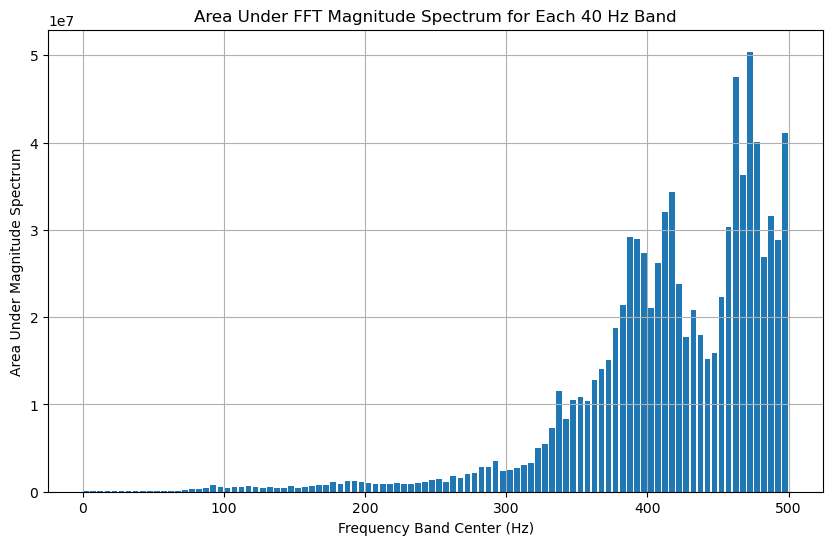

In [ ]:
band_width = 5
max_freq = 750
num_bands = int(max_freq / band_width)
band_areas = []
band_centers = []

for i in range(num_bands):
    # Define band range
    band_start = i * band_width
    band_end = min((i + 1) * band_width, max_freq)
    
    # Mask to select frequency range within the band
    band_mask = (fft_freq >= band_start) & (fft_freq < band_end)
    
    # Calculate area under the magnitude within this band
    band_area = np.trapz(magnitude[band_mask], fft_freq[band_mask])
    band_areas.append(band_area)
    band_centers.append((band_start + band_end) / 2)  # Center frequency of the band

# Plot the area under each band
plt.figure(figsize=(10, 6))
plt.bar(band_centers, band_areas, width=band_width * 0.8, align='center')  # Adjust width for spacing
plt.xlabel('Frequency Band Center (Hz)')
plt.ylabel('Area Under Magnitude Spectrum')
plt.title('Area Under FFT Magnitude Spectrum for Each 40 Hz Band')
plt.grid()
plt.show()

In [29]:
df = pd.DataFrame(band_areas, columns=['Power'])
df = df.T; 
df['Label'] = "W"; 
df.head(50)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Label
Power,29348.880005,29350.234799,29365.492723,29420.510436,29567.080453,29878.997766,30066.945791,30684.866179,31224.629444,38875.643539,...,3.035722e+07,4.745521e+07,3.632649e+07,5.040835e+07,4.007978e+07,2.694790e+07,3.158346e+07,2.881882e+07,4.115114e+07,W


# ML WORK

In [30]:
X = df.drop(columns='Label')
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.